# Lasso Regression

# Datenimport

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns  

In [2]:
# seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Data Import
df = pd.read_csv("ready_data.csv")

# Change Datatypes from Data.ipynb
datatypes_toChange = {"priceCat": "category", "proximity": "category"}
df = df.astype(datatypes_toChange)

df

,housing_median_age,median_income,median_house_value,priceCat,person_per_household,share_bedrooms,rooms_per_household,sm_PpH,sm_RpH,proximity
0,41.0,8.3252,452.6,above,2.555556,0.146591,6.984127,0.938270,1.943640,COAST
1,21.0,8.3014,358.5,above,2.109842,0.155797,6.238137,0.746613,1.830682,COAST
2,52.0,7.2574,352.1,above,2.802260,0.129516,8.288136,1.030426,2.114825,COAST
3,52.0,5.6431,341.3,above,2.547945,0.184458,5.817352,0.935287,1.760845,COAST
4,52.0,3.8462,342.2,above,2.181467,0.172096,6.281853,0.779998,1.837665,COAST
...,...,...,...,...,...,...,...,...,...,...
19369,25.0,1.5603,78.1,below,2.560606,0.224625,5.045455,0.940244,1.618488,INLAND
19370,18.0,2.5568,77.1,below,3.122807,0.215208,6.114035,1.138732,1.810587,INLAND
19371,17.0,1.7000,92.3,below,2.325635,0.215173,5.205543,0.843993,1.649724,INLAND
19372,18.0,1.8672,84.7,below,2.123209,0.219892,5.329513,0.752929,1.673260,INLAND


# Vorgehensweise

In den nachfolgenden Punkten wird die Lasso Regression jeweils einmal mit **SK Learn** und **Statsmodels** durchgeführt.</br>
Dabei sind unterschiedliche Vorgehensweisen bzgl. Einlesen der Daten zu beachten.

Vorarbeit wurde bereits in Data.ipynb erbracht.

Ferner wird in SK Learn der Hyperparameter Lambda mittels Cross-Validation ermittelt.

# Modellierung in SK Learn Pipeline

Nachfolgend die Lasso-Regression in der SK-Learn Pipeline.

Zum Ende wird der Hyperparameter Lambda ausgegeben.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [4]:
# create label
y = df['median_house_value']

# create features
X = df.drop(['sm_PpH','sm_RpH','median_house_value', 'share_bedrooms', "priceCat"], axis=1)

# create list of feature names
num_feature_names =  X.columns


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_train.head()

,housing_median_age,median_income,person_per_household,rooms_per_household,proximity
5117,41.0,4.0231,2.064449,4.330561,COAST
2566,14.0,5.0329,2.850829,8.022099,COAST
306,52.0,2.4659,2.942857,5.782857,COAST
17621,23.0,2.3571,2.639742,6.489499,INLAND
13146,18.0,3.0139,2.443359,6.468750,INLAND


In [6]:
col_log_ = ["rooms_per_household", "person_per_household"]
med_log_ = 'median_income'

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
    ])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, selector(dtype_include="category")),
    ('logTrans', FunctionTransformer(np.log),col_log_),
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ])

In [7]:
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=10, max_iter=10000))
    ])

In [8]:
# show pipeline
set_config(display="diagram")
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f75746f40>),
                                                 ('logTrans',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['rooms_per_household',
                                                   'person_per_household']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f6f9e1730>)])),
                ('lasso', LassoCV(cv=5, max_iter=10000, random_state=10))])

In [9]:
reg = lm_pipe.named_steps['lasso']

In [10]:
y_pred = lm_pipe.predict(X_test)

In [11]:
print('R squared training set', round(lm_pipe.score(X_train, y_train)*100, 2))
print('R squared test set', round(lm_pipe.score(X_test, y_test)*100, 2))

R squared training set 62.69
R squared test set 62.47


In [12]:
print("RMSE training set", mean_squared_error(y_train, lm_pipe.predict(X_train), squared=False))
print("RMSE test set", mean_squared_error(y_test, lm_pipe.predict(X_test), squared=False))

RMSE training set 59.32230302453848
RMSE test set 59.49359330803611


In [65]:
print("Lambda:", reg.alpha_)

Lambda: 0.063103048006874


Laut Ausgabe ist der Hyperparameter Lambda = 0.063103048006874

Der nachfolgende Plot sollte eigentlich eine Darstellung über die Folds bei Cross-Validation=5 erstellen.
Eventuell fehlt die Anzeige wegen dem Abruf aus der Pipeline mit *reg = lm_pipe.named_steps['lasso']*. </br>
Eine Kontrolle über den manuellen Weg mit dem ausgeworfenen Lambda ist möglich und wurde für das nachfolgende Statsmodels geplant. Die Umsetzung in SKLearn fehlte im Nachgang die Zeit.

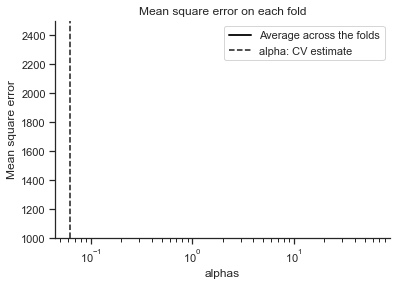

In [66]:
plt.semilogx(reg.alphas_, reg.mse_path_, ":")
plt.plot(
    reg.alphas_ ,
    reg.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    reg.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 1000, 2500
plt.ylim(ymin, ymax);

# Modellierung in Statsmodels

Nachfolgend wird die Vorbereitung für die Lasso Regression dargestellt. Dies erfolgt bis zur Standardisierung von allen nummerischen Spalten.</br>
Mittlerweile gibt es eine Funktion bei Statsmodels, welche jedoch noch nicht ausgereift ist. Beispielsweise scheint die Funktion zur Ausgabe von üblichen Summary-Werten wie MSE und R2 zu fehlen.

Der Umfang wird in diesem Notebook aufgenommen, weil sehr viel Zeit in die Recherche geflossen ist. :-)

In [17]:
%matplotlib inline

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.genmod.generalized_linear_model as slm
from statsmodels.tools.eval_measures import mse, rmse

sns.set_theme(style="ticks", color_codes=True)

In [4]:
df_stats = pd.concat([df, dummies[["Ocean_Prox_INLAND","priceCat_below"]]], axis=1)
df_stats = df_stats.drop(columns=["Ocean_Prox", "priceCat"], axis=1)
numeric_feature_names = df_stats.drop(columns=["Ocean_Prox_INLAND", "priceCat_below", "median_house_value"],axis=1).columns

In [5]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [6]:
train_dummies = pd.get_dummies(train_dataset[['priceCat', 'Ocean_Prox']], drop_first=True)
test_dummies = pd.get_dummies(test_dataset[['priceCat', 'Ocean_Prox']], drop_first=True)


In [7]:
y_train_dataset = train_dataset["median_house_value"]
X_train_dataset = pd.concat([train_dataset.drop(columns=["median_house_value", 'priceCat','Ocean_Prox'], axis=1), train_dummies],axis=1)
y_test_dataset = test_dataset["median_house_value"]
X_test_dataset = pd.concat([test_dataset.drop(columns=["median_house_value", 'priceCat','Ocean_Prox'], axis=1), test_dummies],axis=1)

print(len(y_train_dataset))
print(len(X_train_dataset))

15450
15450


In [8]:
from scipy import stats
#pd.concat([df, dummies[["Ocean_Prox_INLAND","priceCat_below"]]], axis=1)
X_train_dataset_z = pd.concat([X_train_dataset[numeric_feature_names].apply(stats.zscore), train_dummies[["Ocean_Prox_INLAND","priceCat_below"]]], axis=1)
X_test_dataset_z = pd.concat([X_test_dataset[numeric_feature_names].apply(stats.zscore), test_dummies[["Ocean_Prox_INLAND","priceCat_below"]]], axis=1)
X_train_dataset_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15450 entries, 6109 to 15656
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   housing_median_age   15450 non-null  float64
 1   median_income        15450 non-null  float64
 2   Person_per_Houshold  15450 non-null  float64
 3   Share_Bedrooms       15450 non-null  float64
 4   Rooms_per_Houshold   15450 non-null  float64
 5   Ocean_Prox_INLAND    15450 non-null  uint8  
 6   priceCat_below       15450 non-null  uint8  
dtypes: float64(5), uint8(2)
memory usage: 754.4 KB


# Modellierung
Für statsmodel scheint noch keine ausgereifte Funktionalität bei Lasso-Regression zu bestehen.

Hier wurde das Alpha aus der SK Learn Pipeline exemplarisch eingesetzt.

In [34]:
# Fit Model
#lasso_reg = slm.GLM(y_train_dataset,X_train_dataset_z).fit_regularized(method="",alpha=0.063103048006874, L1_wt=1)